In [1]:
import sys
sys.path.append('/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages')

In [3]:
import glob
import json
import os

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from PIL import Image

# Albumentations

Albumentations is a python library for image augmentation. Almost every time you train a convolutional neural network, you need to use image augmentation to reduce overfitting and increase the variability in your dataset.

## Simple augmentations

Let's visualize the original image. Albumentations expects numpy array so we will convert the Pillow image to a numpy array.

In [5]:
img = Image.open('data/00012_00027.jpg').convert('RGB')
img = np.array(img)

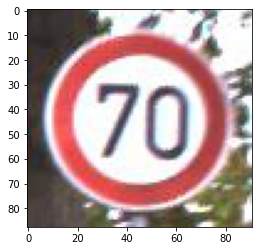

In [6]:
plt.imshow(img)
plt.show()

Let's experiment with rotation. To create a rotation augmentation, you need to use the `A.Rotate` function. In the parameters, you can set the `limit` which is the rotation angle in degrees. 

Albumentations augmentations always have the following parameters:
* **p [float]**: probability to apply this augmentations
* **always_apply [bool]**: always apply this augmentation or not

In [7]:
augmentation = A.Rotate(limit=90, always_apply=True)

We apply the augmentation by running:

In [8]:
augmented = augmentation(image=img)

And we can get the augmented image:

In [9]:
augmented_img = augmented['image']

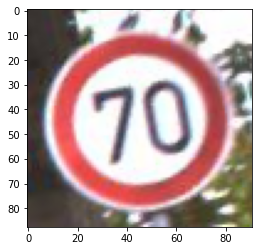

In [10]:
plt.imshow(augmented_img)
plt.show()

## Compose augmentations

We can use `Compose` to combine multiple augmentations. `Compose` takes a list of augmentations.

In [11]:
augmentations = A.Compose([A.Rotate(limit=90, p=1.0), 
                           A.RandomContrast(p=1.0),
                           A.CoarseDropout(p=1.0)])

/opt/anaconda3/envs/self_driving_car/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1770: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [12]:
augmented = augmentations(image=img)
augmented_img = augmented['image']

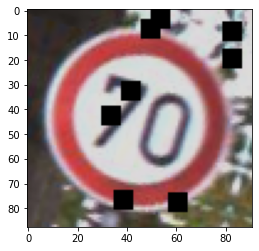

In [13]:
plt.imshow(augmented_img)
plt.show()

## Augmentations with bounding boxes

Finally, we can also apply augmentations to image with bounding boxes.

Let's load an image

In [14]:
img = Image.open('data/segment-12208410199966712301_4480_000_4500_000_with_camera_labels_83.png').convert('RGB')
img = np.array(img)

And the corresponding annotations

In [15]:
with open('data/ground_truth.json') as f:
    annotations = json.load(f)

We can display the original image with the annotations

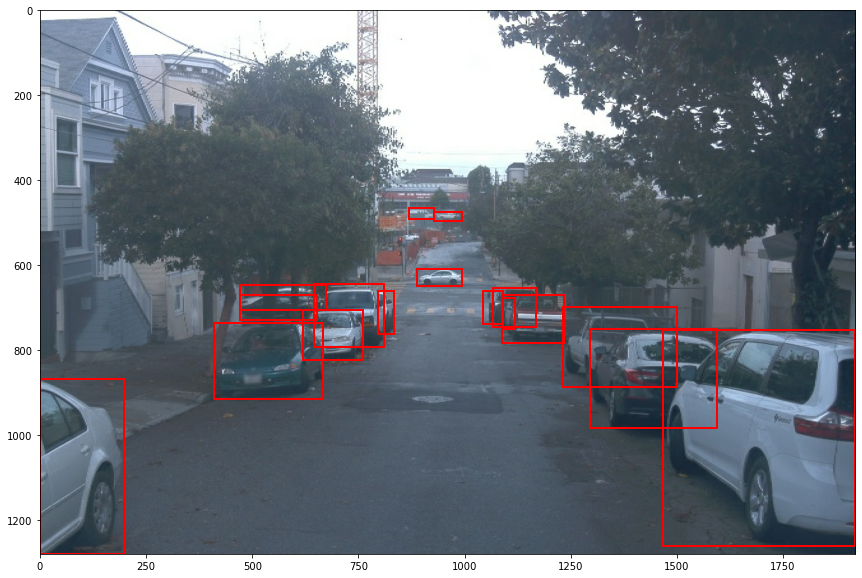

In [16]:
f, ax = plt.subplots(1, figsize=(15,10))
ax.imshow(img)
for bb in annotations['boxes']:
    y1, x1, y2, x2 = bb
    rec = Rectangle((y1, x1), y2-y1, x2-x1, facecolor='none', edgecolor='r', linewidth=2)
    ax.add_patch(rec)
plt.show()

Let's define a list of augmentations. We are going to flip the image horizontally, randomly crop it and apply couple pixel level transformations

In [17]:
augmentations =[A.RandomResizedCrop(height=1024, width=1024, p=1.0),
                A.HorizontalFlip(p=1.0),
                A.RandomContrast(p=1.0),
                A.CoarseDropout(max_height=30, max_width=30, p=1.0)]

When creating the composition, we need to add an extra argument. 

`bbox_params` will describe the following:
* the bounding boxes format. In our case, we use the x1, y1, x2, y2 format, which corresponds to the Pascal VOC dataset.
* the `min_area` argument controls the minimum area of the augmented bounding boxes. After cropping or resizing, if a bounding box area is under this threshold, it will be deleted.
* the `label_fields` argument just set the name of the classes id field in our input dictionnary

In [18]:
augmentations = A.Compose(augmentations,
                          bbox_params=A.BboxParams(format='pascal_voc', 
                                                   min_area=100,
                                                   label_fields=['classes']))

Let's create the input dictionnary

In [19]:
input_data = {'image': img,
              'bboxes': annotations['boxes'],
              'classes': annotations['classes']}

In [21]:
augmented = augmentations(**input_data)

NotImplementedError: Method apply_to_bbox is not implemented in class CoarseDropout

Finally we can display the augmented image with the corresponding bounding boxes

KeyError: 'bboxes'

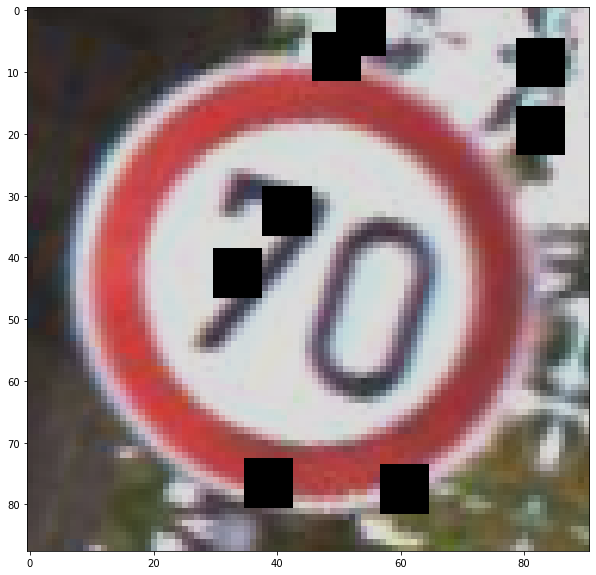

In [22]:
f, ax = plt.subplots(1, figsize=(15,10))
ax.imshow(augmented['image'])
for bb in augmented['bboxes']:
    y1, x1, y2, x2 = bb
    rec = Rectangle((y1, x1), y2-y1, x2-x1, facecolor='none', edgecolor='r', linewidth=2)
    ax.add_patch(rec)
plt.show()